In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils.rnn import pad_sequence
from torch.autograd import Variable 

In [18]:
# device가 cuda 면 --> GPU 사용, cpu 면 cpu 사용하는 것임.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

# pandas 함수를 사용해 csv에서 원하는 데이터셋을 들고옴.
rawdata = pd.read_csv("DatasetCSV/TrainData.csv")

# OUTPUT Fx, Fy, Fz
Data_foot_Fx = rawdata["Fx_foot"]
Data_foot_Fy = rawdata["Fy_foot"]
Data_foot_Fz = rawdata["Fz_foot"]

# OUTPUT Fx, Fy, Fz Label array를 만들기 위한 코드 부분-차원 (71993, 3)
##################################################
len_data = len(Data_foot_Fx)
output_array = np.empty((0,3))
output_data_list = []
        
for i in range(len_data):
    output_data_list.append(Data_foot_Fx[i])
    output_data_list.append(Data_foot_Fy[i])
    output_data_list.append(Data_foot_Fz[i])
    
    if len(output_data_list) == 3:
        output_array = np.append(output_array, np.array([output_data_list]), axis = 0) 
        output_data_list = []

output_train_data = output_array[0:71993:]
##################################################

print(output_train_data.shape)

device = cuda
(71993, 3)


In [19]:
# INPUT KP_q_error, KP_qdot_erro, Z_error, Tor_HR, Tor_HP, Tor_KP
Data_knee_pitch_q_error = rawdata["q_err_KP"]
Data_knee_pitch_q_dot_error = rawdata["qdot_err_KP"]
Data_Z_error = rawdata["z_error"]
Data_hip_roll_Torque = rawdata["Tor_HR"]
Data_hip_pitch_Torque = rawdata["Tor_HP"] 
Data_knee_pitch_Torque = rawdata["Tor_KP"]

# INPUT array를 만들기 위한 코드 부분-차원 (71993, 7, 6)
##################################################
len_data = len(Data_knee_pitch_q_error)
input_array = np.empty((0,6))
input_data_list = []

for i in range(len_data):
    input_data_list.append(Data_knee_pitch_q_error[i])
    input_data_list.append(Data_knee_pitch_q_dot_error[i])
    input_data_list.append(Data_Z_error[i])
    input_data_list.append(Data_hip_roll_Torque[i])
    input_data_list.append(Data_hip_pitch_Torque[i])
    input_data_list.append(Data_knee_pitch_Torque[i])
    
    if len(input_data_list) == 6:
        input_array = np.append(input_array, np.array([input_data_list]), axis = 0) 
        input_data_list = []

input_train_dataset = input_array[0:72000:]
input_array_test = np.array(input_array)

# LSTM window size를 위한 함수 부분 seq_length --> window size
seq_length = 7

def build_dataset(time_series_data, sequence_length):
    data = []
    for i in range(0, len(time_series_data)-sequence_length):
        _x = time_series_data[i:i+sequence_length, :]
        data.append(_x)        
    return np.array(data)

input_train_data = build_dataset(input_train_dataset, seq_length)
##################################################

print(f'input_train_data = {input_train_data.shape}')
print(f'output_train_data = {output_train_data.shape}')

input_train_data = (71993, 7, 6)
output_train_data = (71993, 3)


In [20]:
# Batch size
batch_size = 32

# INPUT, OUTPUT array --> Tensor
output_train_dataset = torch.FloatTensor(output_train_data).to(device)
input_train_dataset = torch.FloatTensor(input_train_data).to(device)

# INPUT, OUTPUT TensorDataset(input, output) --> DataLoader(Dataset, batch_size, data_shuffle = True/False)
train_dataset = TensorDataset(input_train_dataset, output_train_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [29]:
data_dim = 6           # Input data 차원
hidden_dim = 10        # hidden 노드 차원
output_dim = 3         # Output data 차원
learning_rate = 0.01   # Adam Optimizer learning_rate
epochs = 1             # epoch 수
lstm_layers = 3        # lstm 층 개수


# pytorch --> torch.nn 의 nn.LSTM 모델을 사용한 model Class
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, sequence_len, output_dim, layers, dropout=0.1):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = sequence_len
        self.output_dim = output_dim
        self.layers = layers
        
        # nn.LSTM(input차원사이즈, output차원사이즈, Lstm층수, batch_first = True)
        # batch_first = True --> Input 차원 (batch_size, sequence_len, input_dim)
        # 현재 Input 차원 --> (32, 7, 6)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        # 마지막에 Fx, Fy, Fz로 바꾸기 위해 노드 수를 3개로 맞춰줌.
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True)
        
        
    def forward(self,x):
        
        # LSTM hidden layer 변수, cell state 변수 초기화
        h_0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_dim)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_dim)).to(device) #internal state   

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
#         print(f'x = {x.shape}')                # shape --> (32, 7, 10)                  
#         print(f'x[:, -1] = {x[:, -1].shape}')  # shape --> (32, 10) 7개중 마지막 결과값 받아옴--> 마지막 도출값을 label과 비교
        out = self.fc(output[:, -1]) # shape --> (32, 3)
        return out

# LSTM 모델 Class 생성
net_lstm = Net(data_dim, hidden_dim, seq_length, output_dim, lstm_layers).to(device) 

In [30]:
# train 하기 위한 함수 부분
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 20):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters())
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            outputs = model(x_train)
            loss = criterion(outputs, y_train)                    

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
    return model.eval(), train_hist

In [31]:
# model Training
model, train_hist = train_model(net_lstm, train_loader, num_epochs = epochs, lr = learning_rate, verbose = 20)

Epoch: 0000 train loss : 69.3872


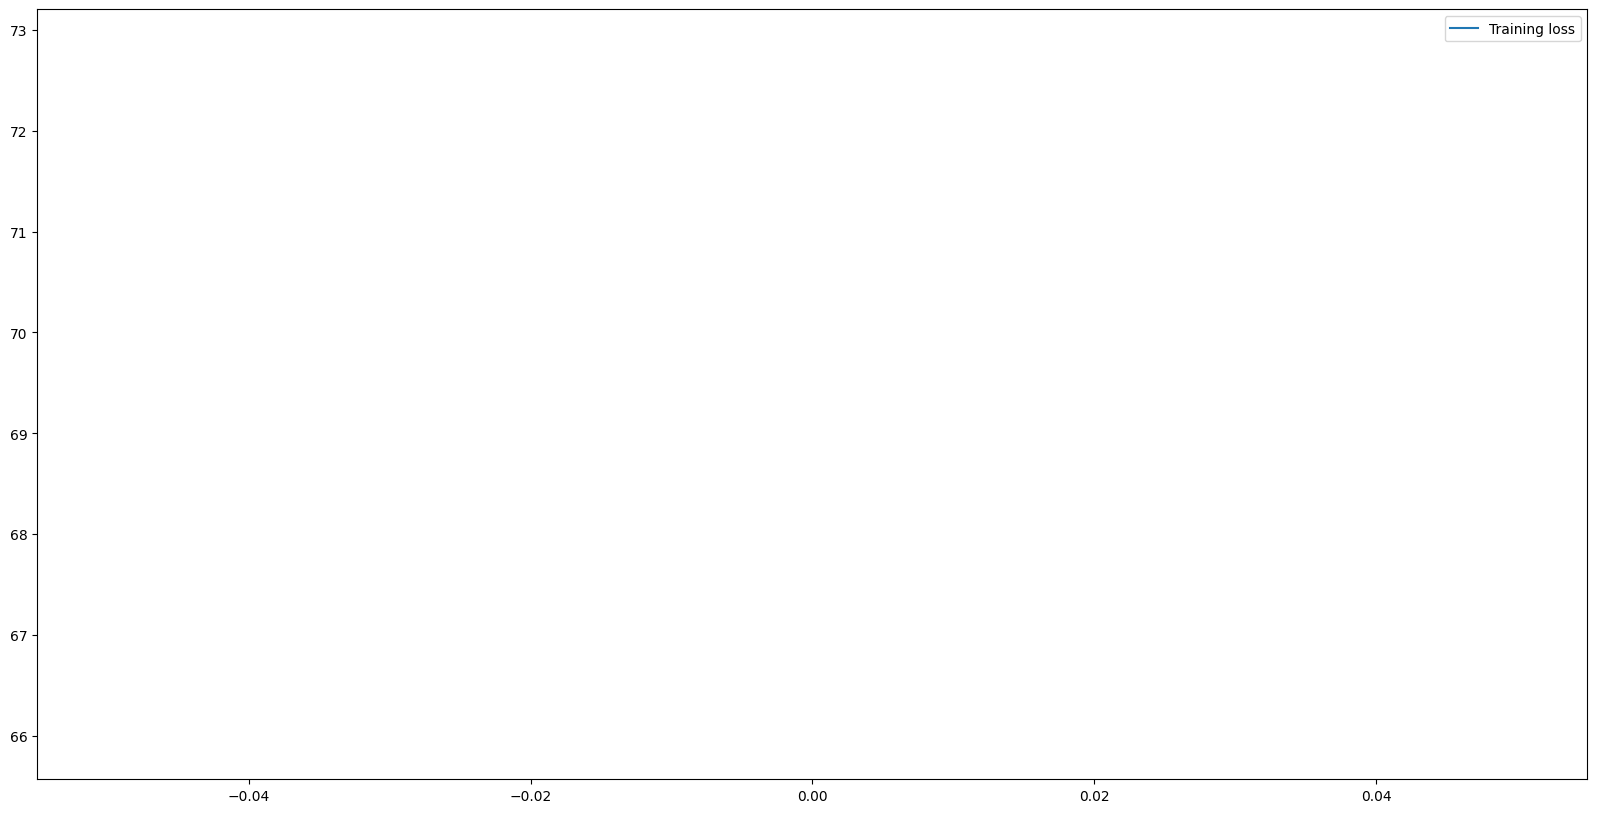

In [32]:
# Training Loss Plotting
fig = plt.figure(figsize=(20, 10))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
# 모델 파라미터 Weight 저장
# torch.save(model.state_dict(), 'Weights/Lstm_FxFyFz_take19_weights.pth')